# Pytorch Cheatsheet

## Overview

In [13]:
* How does a Conv layer impact the size of output feature maps?
* How does a Conv Transpose layer impact the size of the output feature maps?
* How does padding / stride impact both of the above?

Normal Convolution
* W2 = (W1 - KS + 2P)/S + 1

Convolution Transpose
* W2 = S(W1 - 1) + KS - 2P

SyntaxError: invalid syntax (<ipython-input-13-5efeee96745a>, line 5)

## Resources

In [14]:
* ss
* ss
* ss

SyntaxError: can't use starred expression here (<ipython-input-14-5a53398567fd>, line 1)

## Imports

In [60]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_img_utils
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
import cv2
import scipy.misc
from glob import glob
import sklearn

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Basics

## Tutorials

* [Official Pytorch Tutorials](http://pytorch.org/tutorials/)
* [Pytorch Documentation](http://pytorch.org/docs)

# Datasets

## File Management

In [16]:
random.seed(1)
torch.manual_seed(1)
DATA_PATH='/media/bfortuner/bigguy/data/'
CUB_PATH=DATA_PATH+'cub/'
CUB_IMAGES_PATH=CUB_PATH+'images/'
MNIST_PATH=DATA_PATH+'mnist/'
MNIST_WEIGHTS_PATH=MNIST_PATH+'weights/'
MNIST_RESULTS_PATH='results/'
CIFAR10_PATH=DATA_PATH+'cifar10/'
CIFAR10_IMGS_PATH=CIFAR10_PATH+'images/'
CIFAR10_RESULTS_PATH=CIFAR10_PATH+'results/'
CIFAR10_WEIGHTS_PATH=CIFAR10_PATH+'weights/'

In [17]:
def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames if not f[0] == '.')
        fnames.extend([f for f in filenames if not f[0] == '.'])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

## MNIST

In [18]:
MNIST_BATCH_SIZE = 128
MNIST_MEAN = np.array([0.1307,])
MNIST_STD = np.array([0.3081,])
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE*8, shuffle=True)

mnist_train_labels = mnist_train_loader.dataset.train_labels
MNIST_CLASSES = np.unique(mnist_train_labels.numpy())
print("MNIST Train Samples:", len(mnist_train_loader.dataset))
print("MNIST Test Samples:", len(mnist_test_loader.dataset))

MNIST Train Samples: 60000
MNIST Test Samples: 10000


## CIFAR10

In [41]:
CIFAR_BATCH_SIZE = 64
CIFAR_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
CIFAR_STD = np.array([0.24703233, 0.24348505, 0.26158768])
normTransform = transforms.Normalize(CIFAR_MEAN, CIFAR_STD)

trainTransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normTransform
])
testTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform
])

cifar_train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=True, download=True,
                 transform=trainTransform),
    batch_size=CIFAR_BATCH_SIZE, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=False, download=True,
                 transform=testTransform),
    batch_size=CIFAR_BATCH_SIZE*16, shuffle=False)

cifar_classes = cifar_train_loader.dataset.train_labels
CIFAR_CLASSES = np.unique(np.array(cifar_classes))
CIFAR_CLASS_NAMES = np.array(['airplane','automobile','bird','cat',
                          'deer','dog','frog', 'horse','ship','truck'])
print("CIFAR Train Samples:", len(cifar_train_loader.dataset))
print("CIFAR Test Samples:", len(cifar_test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
CIFAR Train Samples: 50000
CIFAR Test Samples: 10000


## Swiss Roll


 11.2859  -4.4224
  9.7413   9.7744
 10.7755  -4.8743
  8.2207  10.6784
 -0.8344 -11.3071
 -2.7668 -10.5984
 11.7795  -3.4875
 -6.6013  -7.8201
 -4.7877  -9.2370
 -6.1006  -8.7008
 -8.1754  -6.1561
 -1.8350   7.9860
  7.1470  -8.8236
  3.5312   6.1914
 -8.8901  -3.9086
  4.7486  -2.7880
 10.5335  -6.0866
  4.6021  -3.2873
 -4.6778   7.1029
 -7.9958   3.1143
 -9.6130   1.5783
  2.0332   7.3880
 -6.6942  -7.8496
  6.5717  -0.2127
 -0.8685 -11.0825
  0.7146  -4.9460
 -5.1389   6.8356
  4.0975  -3.3304
 -1.4073   7.8709
  6.1093   2.4540
  2.9354  -4.6179
 12.6135   3.1774
 -9.0066  -3.7590
  1.0331 -11.0076
  2.1664 -10.9575
 -8.8992  -4.8085
  1.0081  -4.5886
 -9.3248   0.9309
 12.6142   0.2867
 11.2504  -4.4437
  1.6806 -10.9212
  2.0674 -10.7526
 -0.3842 -10.9054
 12.3477  -2.2549
 -7.3852  -6.8657
  2.8458  -4.2350
 -9.5080  -1.0432
  0.1223   7.5927
 11.3272   7.3686
  9.0065   9.6114
  1.5104   7.4256
 -3.5433  -9.8809
  1.4911  13.8762
  6.5093   0.4793
  1.4910  13.9619
  1.9456 

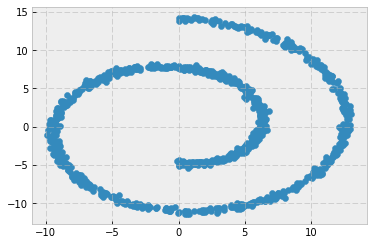

In [175]:
from sklearn.datasets.samples_generator import make_swiss_roll

def get_swiss_roll(n_samples=100):
    noise = 0.2
    X, _ = make_swiss_roll(n_samples, noise)
    X = X.astype('float32')[:, [0, 2]]
    return X, _

def plot_roll(data):
    # data.shape = (N, 2)
    x = data[:,0]
    y = data[:,1]
    plt.scatter(x,y)

SWISS_ROLL_BATCH_SIZE = 100
X, _ = get_swiss_roll(100)
swiss_roll_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X), torch.FloatTensor(_))
swiss_roll_loader = torch.utils.data.DataLoader(swiss_roll_dataset, batch_size=SWISS_ROLL_BATCH_SIZE, shuffle=True)
    
# Test
data = get_swiss_roll(1000)[0]
plot_roll(data)

inputs,targets = next(iter(swiss_roll_loader))
print(inputs,targets)

# Image Handling

## Preprocessing

## Viewing

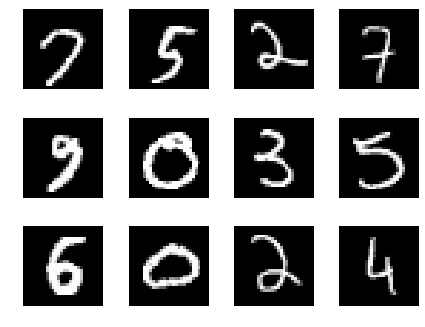

In [42]:
def imshow(inp, mean_arr, std_arr, title=None):
    """Imshow for Tensor."""
    if inp.size(0) == 1:
        inp = np.squeeze(inp.numpy())
        kwargs = {'cmap':'gray'}
    else:
        inp = inp.numpy().transpose((1, 2, 0))
        kwargs = {}
    inp = std_arr * inp + mean_arr
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_preds(model, data_loader, class_names, mean_arr, std_arr, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy()
        labels = labels.data.cpu().numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('P: {}, A:{}'.format(class_names[preds[j][0]], 
                                              class_names[labels[j]]))
            imshow(inputs.cpu().data[j], mean_arr, std_arr)

            if images_so_far == num_images:
                return
        plt.tight_layout()

def plot_mnist_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy()
    bs = arr.shape[0]
    arr = arr.reshape(bs, 28, 28)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

def denorm_meanstd(t, mean, std):
    return (t * std) + mean

def plot_cifar_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((0, 2, 3, 1))
    arr = denorm_meanstd(arr, CIFAR_MEAN, CIFAR_STD)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
def get_cifar_batch_of_size(bs):
    # Return batchsize smaller than 64 for testing
    inputs,targets = next(iter(cifar_test_loader))
    return inputs[:bs], targets[:bs]

def get_mnist_batch(bs):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(MNIST_PATH, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(MNIST_MEAN, MNIST_STD)
                       ])),
        batch_size=bs, shuffle=True)
    inputs,targets = next(iter(train_loader))
    return inputs,targets

inps,targs = get_mnist_batch(12)
plot_mnist_samples(inps)

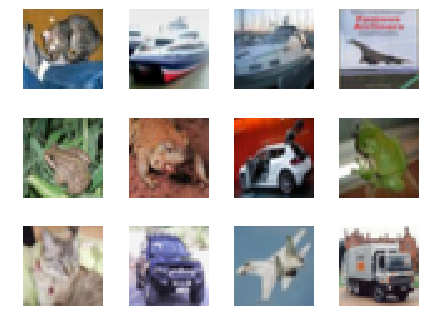

In [43]:
inputs,targets = get_cifar_batch_of_size(12)
plot_cifar_samples(inputs)

# Models

## Linear

In [44]:
class LinearNetMNIST(nn.Module):
    def __init__(self):
        super(LinearNetMNIST, self).__init__()
        #Let's start with an input of (bs, 784)
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    
class LinearNetCIFAR(nn.Module):
    def __init__(self):
        super(LinearNetCIFAR, self).__init__()
        #Let's start with an input of (bs, 3, 32, 32)
        #We flatten it to fit the first linear layer
        #(bs,32*32*3)
        self.layer1 = nn.Linear(3072, 512)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1) #(bs,32*32*3)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x

In [45]:
#MNIST
inputs, targets = get_mnist_batch(2)
net = LinearNetMNIST()
print(net(Variable(inputs)))

#CIFAR
inputs, targets = get_cifar_batch_of_size(2)
net2 = LinearNetCIFAR()
print(net2(Variable(inputs)))

Variable containing:
 0.0856  0.0971  0.0903  0.1015  0.0910  0.0767  0.1473  0.1231  0.1022  0.0853
 0.0841  0.1002  0.0872  0.0988  0.1089  0.0776  0.1262  0.1015  0.0779  0.1376
[torch.FloatTensor of size 2x10]

Variable containing:
 0.1025  0.1128  0.1012  0.0917  0.1088  0.0957  0.1047  0.0971  0.0925  0.0930
 0.1092  0.1095  0.1064  0.0849  0.0987  0.1018  0.0940  0.0921  0.0937  0.1096
[torch.FloatTensor of size 2x10]



## CNN

In [46]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        #Let's start with an input of (bs, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=10, kernel_size=2, stride=1, padding=0)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out

## GAN

# Training

## Helpers

In [47]:
def train(net, dataloader, criterion, optimizer, epoch=1):
    n_batches = len(dataloader)
    total_loss = 0
    for inputs,targets in dataloader:
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda())
        
        ## Forward Pass
        out = net(inputs)
        
        ## Clear Gradients
        net.zero_grad()
        
        ## Get Loss
        loss = criterion(out, targets)
    
        ## Backprop
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data[0]
    
    return total_loss / n_batches

def predict(net, inputs):
    out = net(inputs)
    val,idx = torch.max(out,dim=1)
    return idx.data.cpu().view(-1)

def get_metrics(net, test_loader, criterion):
    data,targets = next(iter(test_loader)) #1000??
    inputs,labels = Variable(data.cuda()), Variable(targets.cuda())
    
    outputs = net(inputs)
    loss = criterion(outputs, labels).data[0]
    
    #Flatten and Get ArgMax to compute accuracy
    val,idx = torch.max(outputs,dim=1)
    predictions = idx.data.cpu().view(-1).numpy()    
    targets = targets.numpy()
    correct = np.sum(predictions==targets)
    accuracy = correct / len(targets)
    
    return loss, accuracy

## MNIST

In [48]:
N_EPOCHS = 5
mnistnet = LinearNetMNIST().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(mnistnet.parameters(), lr=1e-4)

In [49]:
train_loss_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    train_loss = train(mnistnet, mnist_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = get_metrics(mnistnet, mnist_test_loader, criterion)
    print('Epoch %d, TrainLoss: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, train_loss, test_loss, test_acc))
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

Epoch 1, TrainLoss: 1.663, TestLoss: 1.560, TestAcc: 0.911
Epoch 2, TrainLoss: 1.556, TestLoss: 1.540, TestAcc: 0.926
Epoch 3, TrainLoss: 1.546, TestLoss: 1.529, TestAcc: 0.939
Epoch 4, TrainLoss: 1.541, TestLoss: 1.536, TestAcc: 0.928
Epoch 5, TrainLoss: 1.538, TestLoss: 1.538, TestAcc: 0.926


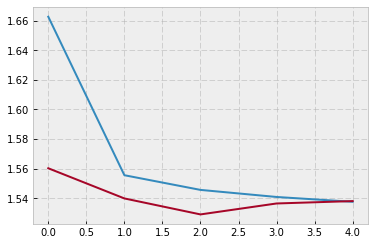

In [50]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

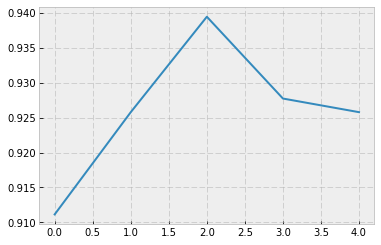

In [51]:
plt.plot(test_acc_history)

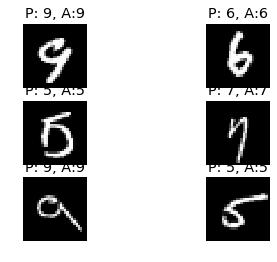

In [52]:
visualize_preds(mnistnet, mnist_test_loader, MNIST_CLASSES, MNIST_MEAN, MNIST_STD, 6)

## CIFAR

In [53]:
N_EPOCHS = 5
cifarnet = LinearNetCIFAR().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(cifarnet.parameters(), lr=1e-4)

In [54]:
train_loss_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    train_loss = train(cifarnet, cifar_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = get_metrics(cifarnet, cifar_test_loader, criterion)
    print('Epoch %d, TrainLoss: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, train_loss, test_loss, test_acc))
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

Epoch 1, TrainLoss: 2.147, TestLoss: 2.077, TestAcc: 0.383
Epoch 2, TrainLoss: 2.092, TestLoss: 2.065, TestAcc: 0.400
Epoch 3, TrainLoss: 2.069, TestLoss: 2.020, TestAcc: 0.439
Epoch 4, TrainLoss: 2.053, TestLoss: 2.016, TestAcc: 0.442
Epoch 5, TrainLoss: 2.041, TestLoss: 2.010, TestAcc: 0.445


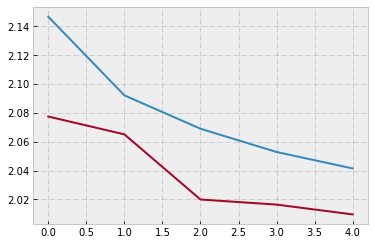

In [55]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

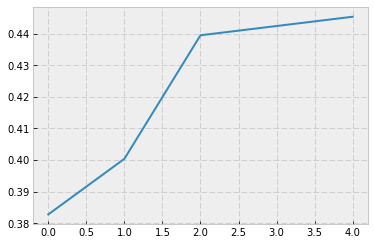

In [56]:
plt.plot(test_acc_history)

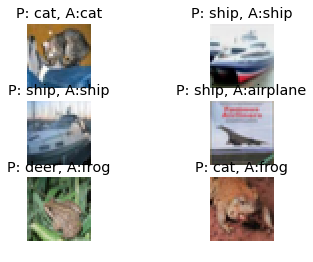

In [57]:
visualize_preds(cifarnet, cifar_test_loader, CIFAR_CLASS_NAMES, CIFAR_MEAN, CIFAR_STD, 6)

# Experiments

## Load/Save Weights

## Visdom Web Server

## Experiment Class

In [58]:
import numpy as np
import os
import torch
import visdom
import shutil
import sys
from pathlib import Path


class Experiment():
    def __init__(self, name, root):
        self.name = name
        self.root = os.path.join(root,name)
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.error_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.viz = visdom.Visdom()
        self.visdom_plots = self.init_visdom_plots()

    def init(self):
        print("Creating new experiment")
        self.init_dirs()
        self.init_history_files()

    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        print("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer

        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)

        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch']+1
        self.load_history_from_file('train')
        self.load_history_from_file('val')

        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir)
        os.makedirs(self.history_dir)
        os.makedirs(self.results_dir)

    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()

    def init_visdom_plots(self):
        loss = self.init_viz_train_plot('loss')
        error = self.init_viz_train_plot('error')
        summary = self.init_viz_txt_plot('summary')
        return {
            'loss':loss,
            'error':error,
            'summary':summary
        }

    def init_viz_train_plot(self, title):
        return self.viz.line(
            X=np.array([1]),
            Y=np.array([[1, 1]]),
            opts=dict(
                xlabel='epoch',
                ylabel=title,
                title=self.name+' '+title,
                legend=['Train', 'Validation']
            ),
            env=self.name
        )

    def init_viz_txt_plot(self, title):
        return self.viz.text(
            "Initializing.. " + title,
            env=self.name
        )

    def viz_epochs(self):
        epochs = np.arange(1,self.epoch+1)
        return np.stack([epochs, epochs],1)

    def update_viz_loss_plot(self):
        loss = np.stack([self.loss_history['train'],
                         self.loss_history['val']],1)
        window = self.visdom_plots['loss']
        return self.viz.line(
            X=self.viz_epochs(),
            Y=loss,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='loss',
                title=self.name+' '+'loss',
                legend=['Train', 'Validation']
            ),
        )

    def update_viz_error_plot(self):
        error = np.stack([self.error_history['train'],
                         self.error_history['val']], 1)
        window = self.visdom_plots['error']
        return self.viz.line(
            X=self.viz_epochs(),
            Y=error,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='error',
                title=self.name+' '+'error',
                legend=['Train', 'Validation']
            )
        )

    def update_viz_summary_plot(self):
        trn_loss = self.loss_history['train'][-1]
        val_loss = self.loss_history['val'][-1]
        trn_err = self.error_history['train'][-1]
        val_err = self.error_history['val'][-1]
        txt = ("""Epoch: %d
            Train - Loss: %.3f Err: %.3f
            Test - Loss: %.3f Err: %.3f""" % (self.epoch,
            trn_loss, trn_err, tst_loss, tst_err))
        window = self.visdom_plots['summary']
        return self.viz.text(
            txt,
            win=window,
            env=self.name
        )

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
        self.loss_history[dset_type] = data[:,1]
        self.error_history[dset_type] = data[:,2]

    def append_history_to_file(self, dset_type, loss, error):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, error))

    def save_history(self, dset_type, loss, error):
        self.loss_history[dset_type] = np.append(
            self.loss_history[dset_type], loss)
        self.error_history[dset_type] = np.append(
            self.error_history[dset_type], error)
        self.append_history_to_file(dset_type, loss, error)

        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch

    def is_best_loss(self, loss):
        return loss < self.best_val_loss

    def save_weights(self, model, trn_loss, val_loss, trn_err, val_err):
        weights_fname = self.name+'-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            epoch, trn_loss, trn_err, val_loss, val_err)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
                'last_epoch': self.epoch,
                'trn_loss': trn_loss,
                'val_loss': val_loss,
                'trn_err': trn_err,
                'val_err': val_err,
                'best_val_loss': self.best_val_loss,
                'best_val_loss_epoch': self.best_val_loss_epoch,
                'experiment': self.name,
                'state_dict': model.state_dict()
            }, weights_fpath )
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        print("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        print (state['trn_err'], state['val_loss'], state['val_err'])
        print("loaded weights from experiment %s (last_epoch %d, trn_loss %s, trn_err %s, val_loss %s, val_err %s)" % (
                  self.name, state['last_epoch'], state['trn_loss'],
                    state['trn_err'], state['val_loss'], state['val_err']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name+'-optim-%d.pth' % (epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
                'last_epoch': self.epoch,
                'experiment': self.name,
                'state_dict': optimizer.state_dict()
            }, optim_fpath )
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_path

    def load_optimizer(self, optimizer, fpath):
        print("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        print("loaded optimizer from session {}, last_epoch {}"
              .format(optim['experiment'], optim['last_epoch']))
        return optim



# Examples

Links To Pytorch Implementations of cool new models

## CNNs

 * [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py)
 * [ResNet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)
 * [InceptionNet](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)
 * [SqeezeNet](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)
 * [DenseNet](https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py)
 * [FCDenseNet (Tiramisu)](https://github.com/bfortuner/pytorch_tiramisu/blob/master/tiramisu-pytorch.ipynb)
 * [Sub-pixel CNN (superresolution)](https://github.com/pytorch/examples/tree/master/super_resolution)

## GANs

* [DCGAN](https://github.com/pytorch/examples/tree/master/dcgan)
* [Wasserstein GAN](https://github.com/martinarjovsky/WassersteinGAN)

## RNNs

## Other

* [Pytorch Examples](https://github.com/pytorch/examples)